# 06.2 - Pyspark use-case
_aka_  
__We get rid of our training wheels__

Let's do a micro-project. Before you can use the data to train a model, you will need to cross databases, join registries, add columns, replace data...

So far in this course we have been using complete and clean datasets.


We have a collection of databases (just 2, for the sake of time) on the "sparkfiles" directory. The goal is to create a final dataset on top of which we can run some ML model.

The goal is to predict the housing __SalePrice__ target based on other KPIs we have available.

The __houses_A-L.csv__ database is the listing of houses from neighbourhoods whose name starts in the range A to L. It was collected by one team at your company. The __houses_M-Z.csv__ was collected by another team. let's take a look and see if we can use a union on both databases.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('adpro').getOrCreate()

In [2]:
dfal = spark.read.csv("../sparkfiles/houses_A-L.csv")
dfal.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)



Unlike pandas, spark needs a little more guidance when reading from csv files.

In [3]:
dfal = spark.read.option("header", True).csv("../sparkfiles/houses_A-L.csv")
dfal.printSchema()

root
 |-- LotArea: string (nullable = true)
 |-- LivingArea: string (nullable = true)
 |-- NumberBedroom: string (nullable = true)
 |-- TotalRooms: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- YearRemodAdd: string (nullable = true)
 |-- YrSold: string (nullable = true)
 |-- MoSold: string (nullable = true)
 |-- KitchenQual: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- OverallCond: string (nullable = true)
 |-- SalePrice: string (nullable = true)



In [4]:
dfal.show(5)

+-------+----------+-------------+----------+------------+---------+------------+------+------+-----------+----------+-----------+---------+
|LotArea|LivingArea|NumberBedroom|TotalRooms|Neighborhood|YearBuilt|YearRemodAdd|YrSold|MoSold|KitchenQual|Condition1|OverallCond|SalePrice|
+-------+----------+-------------+----------+------------+---------+------------+------+------+-----------+----------+-----------+---------+
|   8450|      1710|            3|         8|     CollgCr|     2003|        2003|  2008|     2|         Gd|      Norm|          5|   208500|
|  11250|      1786|            3|         6|     CollgCr|     2001|        2002|  2008|     9|         Gd|      Norm|          5|   223500|
|   9550|      1717|            3|         7|     Crawfor|     1915|        1970|  2006|     2|         Gd|      Norm|          5|   140000|
|   7420|      1077|            2|         5|     BrkSide|     1939|        1950|  2008|     1|         TA|    Artery|          6|   118000|
|  10652|    

Usually, in a company enviroment, you don't keep data in csvs. The company usually resorts to a "data lake" solution: a large database open to the members of the company with tiers of security. Imagine that you work in customer relations. The GDPR allows you to have access to customer information, provided you sign a [Non-Disclosure Agreement (NDA)](https://en.wikipedia.org/wiki/Non-disclosure_agreement). Breeching such an agreemnt has harsh consequences.

Technical teams often do not have access to customer information, but to activity generated by customers in the assets of the company. For example, at a telco company, technical teams have access to how many calls are being made through a cell tower (a company asset), but no idea who is doing them.

So, it is possible for both the customer and the technical table to reside in the same data lake, but with diferent permission settings. Thus, the data lake is __GDPR compliant__.

Pyspark offers the possibility to register a temporary table on the cluster side. We will first register our two tables, to simulate we are accessing a company's data lake. Only, instead of several TB of information, we are doing kB tables for the sake of speed.

In [5]:
dfal.registerTempTable("houses_a_l")

In [6]:
dfmz = spark.read.option("header", True).csv("../sparkfiles/houses_M-Z.csv")
dfmz.printSchema()

root
 |-- LotArea;SalePrice;LivingArea;NumberBedroom;TotalRooms;Neighborhood;YearBuilt;YearRemodAdd;YrSold;MoSold;KitchenQual;Condition1;OverallCond: string (nullable = true)



Someone placed a ";" instead of a ","

In [7]:
dfmz = spark.read.option("header", True).option("delimiter", ";").csv("../sparkfiles/houses_M-Z.csv")
dfmz.printSchema()

root
 |-- LotArea: string (nullable = true)
 |-- SalePrice: string (nullable = true)
 |-- LivingArea: string (nullable = true)
 |-- NumberBedroom: string (nullable = true)
 |-- TotalRooms: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- YearRemodAdd: string (nullable = true)
 |-- YrSold: string (nullable = true)
 |-- MoSold: string (nullable = true)
 |-- KitchenQual: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- OverallCond: string (nullable = true)



In [8]:
dfmz.registerTempTable("houses_m_z")

At this moment, your entry point to the datalake would could be done via SQL. If you are unfamiliar with SQL, don't worry. The advantage of pyspark is hat you can select the entire table and do just a small preview.

In [9]:
df1 = spark.sql("SELECT * FROM houses_a_l LIMIT 5")
df1.show()

+-------+----------+-------------+----------+------------+---------+------------+------+------+-----------+----------+-----------+---------+
|LotArea|LivingArea|NumberBedroom|TotalRooms|Neighborhood|YearBuilt|YearRemodAdd|YrSold|MoSold|KitchenQual|Condition1|OverallCond|SalePrice|
+-------+----------+-------------+----------+------------+---------+------------+------+------+-----------+----------+-----------+---------+
|   8450|      1710|            3|         8|     CollgCr|     2003|        2003|  2008|     2|         Gd|      Norm|          5|   208500|
|  11250|      1786|            3|         6|     CollgCr|     2001|        2002|  2008|     9|         Gd|      Norm|          5|   223500|
|   9550|      1717|            3|         7|     Crawfor|     1915|        1970|  2006|     2|         Gd|      Norm|          5|   140000|
|   7420|      1077|            2|         5|     BrkSide|     1939|        1950|  2008|     1|         TA|    Artery|          6|   118000|
|  10652|    

In [10]:
df2 = spark.sql("SELECT * FROM houses_m_z LIMIT 5")
df2.show()

+-------+---------+----------+-------------+----------+------------+---------+------------+------+------+-----------+----------+-----------+
|LotArea|SalePrice|LivingArea|NumberBedroom|TotalRooms|Neighborhood|YearBuilt|YearRemodAdd|YrSold|MoSold|KitchenQual|Condition1|OverallCond|
+-------+---------+----------+-------------+----------+------------+---------+------------+------+------+-----------+----------+-----------+
|   9600|   181500|      1262|            3|         6|     Veenker|     1976|        1976|  2007|     5|         TA|     Feedr|          8|
|  14260|   250000|      2198|            4|         9|     NoRidge|     2000|        2000|  2008|    12|         Gd|      Norm|          5|
|  14115|   143000|      1362|            1|         5|     Mitchel|     1993|        1995|  2009|    10|         TA|      Norm|          5|
|  10084|   307000|      1694|            3|         7|     Somerst|     2004|        2005|  2007|     8|         Gd|      Norm|          5|
|  10382|   2

<div class="alert alert-info">
    <b>Question: how can we combine the two tables in a spark dataframe and can we do it right away?<b>
</div>

Even though our prediction target is the __SalePrice__, it is not important for it to be at the end. Pyspark rarely cares about column order. Since our columns have a 1-1 match between both dataframes, we can easily do:

<div class="alert alert-danger">
    <b>We now want the entire table, so we need to rerun the SQL query<b>
</div>

In [11]:
df1 = spark.sql("SELECT * FROM houses_a_l")
df2 = spark.sql("SELECT * FROM houses_m_z")

In [12]:
df1 = df1.select(sorted(df1.columns))
df2 = df2.select(sorted(df2.columns))

In [13]:
df1.show(3)

+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|Condition1|KitchenQual|LivingArea|LotArea|MoSold|Neighborhood|NumberBedroom|OverallCond|SalePrice|TotalRooms|YearBuilt|YearRemodAdd|YrSold|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|      Norm|         Gd|      1710|   8450|     2|     CollgCr|            3|          5|   208500|         8|     2003|        2003|  2008|
|      Norm|         Gd|      1786|  11250|     9|     CollgCr|            3|          5|   223500|         6|     2001|        2002|  2008|
|      Norm|         Gd|      1717|   9550|     2|     Crawfor|            3|          5|   140000|         7|     1915|        1970|  2006|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
only showing 

In [14]:
df2.show(3)

+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|Condition1|KitchenQual|LivingArea|LotArea|MoSold|Neighborhood|NumberBedroom|OverallCond|SalePrice|TotalRooms|YearBuilt|YearRemodAdd|YrSold|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|     Feedr|         TA|      1262|   9600|     5|     Veenker|            3|          8|   181500|         6|     1976|        1976|  2007|
|      Norm|         Gd|      2198|  14260|    12|     NoRidge|            4|          5|   250000|         9|     2000|        2000|  2008|
|      Norm|         TA|      1362|  14115|    10|     Mitchel|            1|          5|   143000|         5|     1993|        1995|  2009|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
only showing 

<div class="alert alert-warning">
    <b>Remember: tables will usually have hundreds of columns. It is too hard to change them by hand.<b>
</div>
        
It is now safe to union the dfs.

In [15]:
df = df1.union(df2)

You can make SQL queries on top of __df__:

In [16]:
df.registerTempTable("houses")

spark.sql("SELECT * FROM houses WHERE kitchenqual='Gd'").show(3)

+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|Condition1|KitchenQual|LivingArea|LotArea|MoSold|Neighborhood|NumberBedroom|OverallCond|SalePrice|TotalRooms|YearBuilt|YearRemodAdd|YrSold|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|      Norm|         Gd|      1710|   8450|     2|     CollgCr|            3|          5|   208500|         8|     2003|        2003|  2008|
|      Norm|         Gd|      1786|  11250|     9|     CollgCr|            3|          5|   223500|         6|     2001|        2002|  2008|
|      Norm|         Gd|      1717|   9550|     2|     Crawfor|            3|          5|   140000|         7|     1915|        1970|  2006|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
only showing 

And since we have python, we can do aggregations. Remember, aggregations are done cluster-side. Returning tens of lines is easier than returning millions:

In [17]:
import pandas as pd
import seaborn as sns

In [18]:
dfpandas = df.groupBy("TotalRooms").count().toPandas()
dfpandas.head()

TotalRooms  count
0          7    329
1         11     18
2          3     17
3          8    187
4          5    275

<div class="alert alert-danger">
    <b>'count' is a reserved pandas name. Never call a column the name of a pandas operation!<b>
</div>

In [19]:
dfpandas.columns = ["TotalRooms", "Counts"]

In [20]:
dfpandas.dtypes

TotalRooms    object
Counts         int64
dtype: object

In [21]:
dfpandas.head()

TotalRooms  Counts
0          7     329
1         11      18
2          3      17
3          8     187
4          5     275

TotalRooms is a string instead of an integer! We need to take notice of the types of the columns going forwards!

In [22]:
dfpandas['TotalRooms'] = pd.to_numeric(dfpandas['TotalRooms'])

In [23]:
dfpandas.sort_values(by='TotalRooms', ascending=True)

TotalRooms  Counts
11           2       1
2            3      17
8            4      97
4            5     275
5            6     402
0            7     329
3            8     187
6            9      75
7           10      47
1           11      18
9           12      11
10          14       1

<AxesSubplot:xlabel='TotalRooms', ylabel='Counts'>

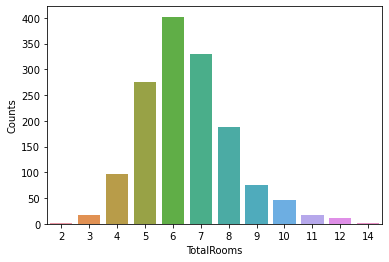

In [24]:
sns.barplot(x='TotalRooms', y='Counts', data=dfpandas)

American houses sure are big!

Our final dataframe is now almost ready to be modelled. We need to make sure the variables have their correct type.

In [25]:
df.printSchema()

root
 |-- Condition1: string (nullable = true)
 |-- KitchenQual: string (nullable = true)
 |-- LivingArea: string (nullable = true)
 |-- LotArea: string (nullable = true)
 |-- MoSold: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- NumberBedroom: string (nullable = true)
 |-- OverallCond: string (nullable = true)
 |-- SalePrice: string (nullable = true)
 |-- TotalRooms: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- YearRemodAdd: string (nullable = true)
 |-- YrSold: string (nullable = true)



In [26]:
df.show(3)

+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|Condition1|KitchenQual|LivingArea|LotArea|MoSold|Neighborhood|NumberBedroom|OverallCond|SalePrice|TotalRooms|YearBuilt|YearRemodAdd|YrSold|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|      Norm|         Gd|      1710|   8450|     2|     CollgCr|            3|          5|   208500|         8|     2003|        2003|  2008|
|      Norm|         Gd|      1786|  11250|     9|     CollgCr|            3|          5|   223500|         6|     2001|        2002|  2008|
|      Norm|         Gd|      1717|   9550|     2|     Crawfor|            3|          5|   140000|         7|     1915|        1970|  2006|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
only showing 

Whlist some variables are definetely categorical, others are numerical. We need to enforce the columns with numerical values to be contain numerical values.

In [27]:
import pyspark.sql.functions as F

In [28]:
cdf = df.withColumn("LivingArea", F.col("LivingArea").cast("bigint"))

In [29]:
cdf.printSchema()

root
 |-- Condition1: string (nullable = true)
 |-- KitchenQual: string (nullable = true)
 |-- LivingArea: long (nullable = true)
 |-- LotArea: string (nullable = true)
 |-- MoSold: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- NumberBedroom: string (nullable = true)
 |-- OverallCond: string (nullable = true)
 |-- SalePrice: string (nullable = true)
 |-- TotalRooms: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- YearRemodAdd: string (nullable = true)
 |-- YrSold: string (nullable = true)



Unfortunately, this is not easy to automate.

In [30]:
cols_to_change = ['LivingArea', 'LotArea', 'MoSold', 'NumberBedroom', 'OverallCond', 'SalePrice', 'TotalRooms', 'YearBuilt', 'YearRemodAdd', 'YrSold']

for col in cols_to_change:
    df = df.withColumn(col, F.col(col).cast("bigint"))

df.printSchema()

root
 |-- Condition1: string (nullable = true)
 |-- KitchenQual: string (nullable = true)
 |-- LivingArea: long (nullable = true)
 |-- LotArea: long (nullable = true)
 |-- MoSold: long (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- NumberBedroom: long (nullable = true)
 |-- OverallCond: long (nullable = true)
 |-- SalePrice: long (nullable = true)
 |-- TotalRooms: long (nullable = true)
 |-- YearBuilt: long (nullable = true)
 |-- YearRemodAdd: long (nullable = true)
 |-- YrSold: long (nullable = true)



In [31]:
df.show(3)

+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|Condition1|KitchenQual|LivingArea|LotArea|MoSold|Neighborhood|NumberBedroom|OverallCond|SalePrice|TotalRooms|YearBuilt|YearRemodAdd|YrSold|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
|      Norm|         Gd|      1710|   8450|     2|     CollgCr|            3|          5|   208500|         8|     2003|        2003|  2008|
|      Norm|         Gd|      1786|  11250|     9|     CollgCr|            3|          5|   223500|         6|     2001|        2002|  2008|
|      Norm|         Gd|      1717|   9550|     2|     Crawfor|            3|          5|   140000|         7|     1915|        1970|  2006|
+----------+-----------+----------+-------+------+------------+-------------+-----------+---------+----------+---------+------------+------+
only showing 

In [32]:
df.registerTempTable("housing_market")

We now have a table at our cluster ready to perform training.

Pyspark has a vectorized ML suite. The same functions you know from scikit-learn are adapted to a distributed environment.

The methodology is the same. What differs is what is under the hood. 

---
## Spark MLlib: classification exercise

I would like to thank professor Susana Brandão for the help in this part.

Spark has a [Machine Learning library](https://spark.apache.org/mllib/) that enables you to do machine learning at scale.

__For a simple example ready to go, with numerical variables alone, [check this notebook](../Examples/04-SimpleLinearRegressionPyspark.ipynb).__

Let's "retrieve" the dataframe from our data lake:

In [ ]:
hm = spark.sql("SELECT * FROM housing_market")

In [ ]:
hm.show(3)

In [ ]:
hm.printSchema()

## MLlib pipes
MlLib allow us to create pipes such as those in sklearn.  
Models usually receive arrays (or arrays of arrays) as input. 
The first thing we need to do is to convert the subset of features we are interessed in to a vector.  
We can handle numerical and categorical features differently:  
**numerical** can be imputed   
**categorical** can be encoded 

### Task 1: Start by checking which variables do you need
- we will use the sale price as our target
- we will impute with mean all numerical features,
- we will do one hot encoding on the categorical features

In [ ]:
#for non categorical variables, check distributions
nonstring_features = [hm.columns[i] for i in range(len(hm.dtypes)) if hm.dtypes[i][1]!='string']
string_features = [hm.columns[i] for i in range(len(hm.dtypes)) if hm.dtypes[i][1]=='string']

In [ ]:
nonstring_features

In [ ]:
string_features

We need to extract the __SalePrice__, as that is our target.

In [ ]:
target = ['SalePrice']
## This might come in handy later
all_nonstring_columns = nonstring_features.copy()
nonstring_features.remove('SalePrice')

In [ ]:
nonstring_features

In [ ]:
all_nonstring_columns

In [ ]:
target

### Task 2: Indexing categories
https://spark.apache.org/docs/2.2.0/ml-features#stringindexer
Gets a column with a categorical variable, and creates a new one -> with a name of our choice -> that converts the variables into ints  
From the doc:


"Additionally, there are three strategies regarding how StringIndexer will handle unseen labels when you have fit a StringIndexer on one dataset and then use it to transform another:
- throw an exception (which is the default)
- skip the row containing the unseen label entirely
- put unseen labels in a special additional bucket, at index numLabels"

In our case, we are will create a new column for each of the categorical variable and create a new one with the suffix _ix  
Neighborhood - Neighborhood_ix    
KitchenQual - KitchenQual_ix  
Condition1 - Condition1_ix

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, Imputer, OneHotEncoder
from pyspark.ml import Pipeline

Index string features -> convert strings to numbers. The indexer detects number of different strings in the column and assigns a number to each of the strings.

At this point, if you had 'null' results, you might want to consider additional cleaning, or just drop those elements.

In [ ]:
indexers = [StringIndexer(inputCol=c, outputCol=c + '_ix', handleInvalid='keep') for c in string_features]

In [ ]:
indexers

In [ ]:
pipe_indexers = Pipeline(stages=indexers)
pipe = pipe_indexers.fit(df)

df_indexer = pipe.transform(df)

df_indexer

In [ ]:
df_indexer.select("Condition1", "Condition1_ix").distinct().toPandas()

### Task 3: Encoding categories

We are going to create a new column for each of the categorical variables and create a new one with the suffix _cVec  

Neighborhood_ix - Neighborhood_cVec   
KitchenQual_ix - KitchenQual_cVec  
Condition1_ix - Condition1_cVec

This is what is called __one-hot encoding__

In [ ]:
encoders = [OneHotEncoder(inputCol=col + "_ix", outputCol=col + "_cVec") for col in string_features]

In [ ]:
encoders

In [ ]:
pipe_indexers = Pipeline(stages=encoders)
pipe = pipe_indexers.fit(df_indexer)
df_encoders = pipe.transform(df_indexer)

What we have done so far is transforming "Condition1" into "Consition1_cVec":

In [ ]:
df_encoders.select("Condition1", "Condition1_ix", "Condition1_cVec").distinct().toPandas()

### Task 4: Impute the numerical variables using a strategy.

We need to tackle missing numerical values. For that we need a "strategy". It could be the median of all values, the mean, a constant value, like zero. We will use the mean and replace inplace. However,

- Imputer only works with doubles or floats, so we need to recast all variables.
- There are two types of strategy, mean and median  
https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.feature.Imputer

Let's recast all numeric columns as double.

In [ ]:
df_encoders = df_encoders.select([F.col(col).astype("double") if col in all_nonstring_columns else col for col in df_encoders.columns])

In [ ]:
df_encoders

Impute the startegy:

In [ ]:
imputer = Imputer(strategy='mean', inputCols=nonstring_features, outputCols=nonstring_features)
pipe_imputer = Pipeline(stages=[imputer]) ## stages need to be a sequence!! 
pipe = pipe_imputer.fit(df_encoders)

df_imputer = pipe.transform(df_encoders)

In [ ]:
df_imputer

### Task 5: Select the variables we want to set up our model

In [ ]:
# the name of the column with a vector with all the assembled features
assembled_col = 'assembled_features'

In [ ]:
# String feature cols after indexing
enc_string_features = [c + '_cVec' for c in string_features]
# Feature cols to assemble
assemble_features = enc_string_features + nonstring_features

In [ ]:
# Assemble feature values to vector form
assembler = VectorAssembler(inputCols=assemble_features, outputCol=assembled_col)
pipe_assembler = Pipeline(stages=[assembler]) ## stages need to be a sequence!! 
pipe = pipe_assembler.fit(df_imputer)

In [ ]:
df_assembled = pipe.transform(df_imputer)

Here we're converting to Pandas so we can have a MarkDown preview

In [ ]:
df_assembled.limit(5).toPandas()

So far, this is an example on how to deal with preparing a table to enable it to run be trained at scale. We did the table handling step-by-step. We can just do it in one go:

### All tasks: Single pipe

In [ ]:
stages_together = [imputer] + indexers + encoders + [assembler]

In [ ]:
stages_together

In [ ]:
df = df.select([F.col(col).astype("double") if col in all_nonstring_columns else col for col in df.columns])

In [ ]:
pipe_together = Pipeline(stages=stages_together) ## stages need to be a sequence!! 
pipe = pipe_together.fit(df)
df_all_at_once = pipe.transform(df)

In [ ]:
df_all_at_once.limit(5).toPandas()

### Now we're ready to use the table

All the steps we did so far were to make sure our numerical representation can be used to train a model. We just perfomed "tidyness" operations so far.

Let's first use a Gradient Boosted Tree classifier, to see if we can predict the price of a house is above a certain threshold, giving the properties of the house.

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [ ]:
df = df.withColumn("target", (F.col("SalePrice")>100000.0).astype("double"))

In [ ]:
gbt = GBTClassifier(
            featuresCol=assembled_col,
            labelCol='target',
            predictionCol='preds',
            lossType='logistic',
            maxDepth=4,
            maxIter=20,
        )

In [ ]:
stages_for_train = [imputer] + indexers + encoders + [assembler] + [gbt]

In [ ]:
pipe_together = Pipeline(stages=stages_for_train) ## stages need to be a sequence!! 
pipe = pipe_together.fit(df)

In [ ]:
df_ex = pipe.transform(df)

In [ ]:
df_ex.select("target", "probability", "preds").toPandas().head()

#### Now a linear regression

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
ldf = spark.sql("SELECT * FROM housing_market")

In [ ]:
ldf.show(3)

In [ ]:
ldf.printSchema()

In [ ]:
lr = LinearRegression(featuresCol=assembled_col,
                      labelCol='SalePrice',
                      maxIter=10,
                      regParam=0.3,
                      elasticNetParam=0.8)

In [ ]:
stages_for_train = [imputer] + indexers + encoders + [assembler] + [lr]

In [ ]:
pipe_together = Pipeline(stages=stages_for_train) ## stages need to be a sequence!! 
#lr_df = pipe_together.fit(df)

In [ ]:
lr_df = pipe_together.fit(df)

In [ ]:
lr_df.stages

In [ ]:
lr_df.stages[-1].summary.r2

In [ ]:
spark.stop()